## Import Libraries

In [107]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib import rcParams

from statsmodels.graphics import tsaplots
import statsmodels.api as sm

## Set Computational Device

In [108]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)

cpu


## Data Pre-Processing

#### Import Data

In [109]:
# data = pd.read_csv('../data/ECONOMICS_USCSHPIMM, 1M.csv')

In [110]:
data = pd.read_csv('ECONOMICS_USCSHPIMM, 1M.csv')

#### Inspect and Reshape Data

In [111]:
# Check layout
data.head()

,time,close
0,949363200,0.8
1,951868800,1.2
2,954547200,1.5
3,957139200,1.6
4,959817600,1.5


In [112]:
# Check for missing data points
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    294 non-null    int64  
 1   close   294 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.7 KB


In [113]:
# Convert time to datetime
data['time'] = pd.to_datetime(data['time'], unit = 's')
data = data.set_index('time')
data.head()

,close
time,
2000-02-01,0.8
2000-03-01,1.2
2000-04-01,1.5
2000-05-01,1.6
2000-06-01,1.5


In [114]:
# Convert to Numpy Array for further processing
data_raw = np.array(data).reshape(-1,1)

#### Data Visualization - Plot Data

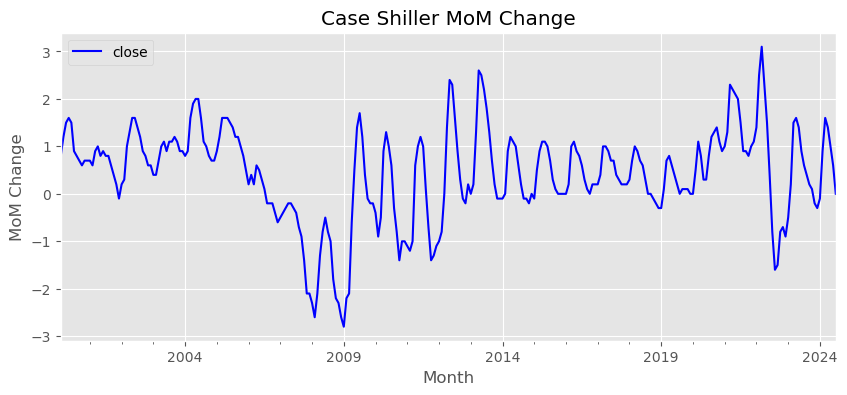

In [115]:
data.plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change")
plt.show()

#### Find Seasonal Component

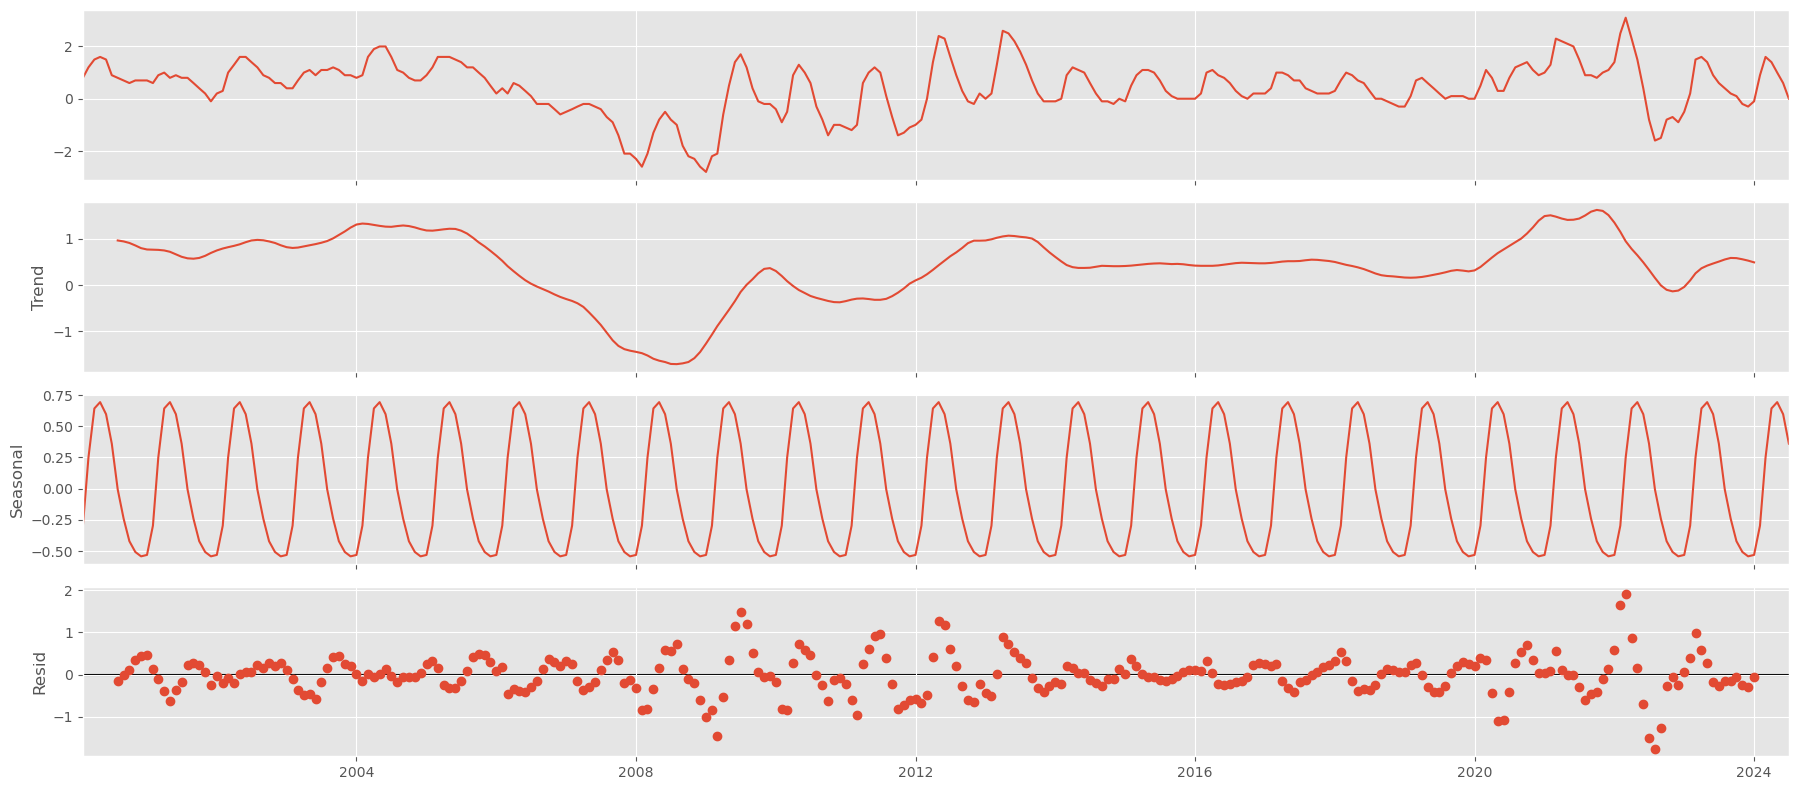

In [116]:
# Time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive')
fig = decomposition.plot()
plt.show()

In [117]:
# Calculate seasonal component length, used to determine train/test split

seasonal_points = np.array(decomposition.seasonal)
# troughs = np.flatnonzero(seasonal_points == np.min(seasonal_points))
# seasonal_length = troughs[1] - troughs[0]
seasonal_length = np.flatnonzero(seasonal_points == np.min(seasonal_points))[1] - np.flatnonzero(seasonal_points == np.min(seasonal_points))[0]

#### Normalize data

In [118]:
# Choose Scaler to use:
# scaler = StandardScaler()
# scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer()

In [119]:
# Scale Data
data_scaled = scaler.fit_transform(data_raw)
data_scaled.shape

(294, 1)

#### Plot Normalized Data

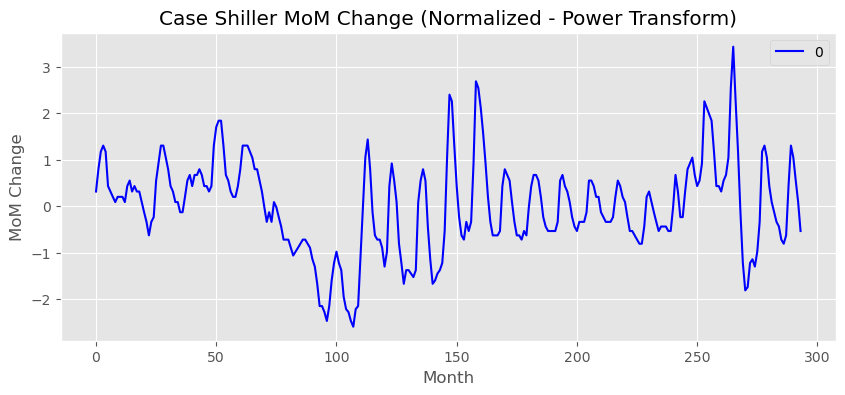

In [120]:
pd.DataFrame(data_scaled).plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change (Normalized - Power Transform)")
plt.show()

#### Train/Test Split

In [121]:
# Split data using 2 seasonal cycles of data to predict
cycles_to_predict = 2

# Calculate train/test split
split = len(data) - (cycles_to_predict * seasonal_length )

# Length of sequences to predict
n_input = len(data) - split

# Target sequence values used to calculate performance metrics 
data_targets = data.to_numpy()[split:]

# Create train and test data sets
train_data = data_scaled[:split]
test_data = data_scaled[split:]
print(train_data.shape)
print(test_data.shape)

(270, 1)
(24, 1)


#### Convert to Sequences

In [122]:
# Convert training data into sequences (sliding windows) needed for LSTM. each sequence of 12 the target is the next value, i.e. 13th.
def create_sequences(data, n_input):
    sequences = []
    for i in range(len(data) - n_input):
        seq = data[i:i + n_input]
        label = data[i + n_input]
        sequences.append((seq, label))
    return sequences

train_sequences = create_sequences(train_data, n_input)

# Convert to PyTorch tensors
train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32).to(device)
train_y = torch.tensor([seq[1] for seq in train_sequences], dtype=torch.float32).to(device)

## Training Set-up (Shared Across Models)

#### Training Parameters

In [123]:
n_features = 1
batch_size = 10
epochs = 100
n_runs = 3

#### Dataset and Dataloader

In [124]:
# Dataset and DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

### Functions

#### Train Model Function

In [125]:
def train_model(model, train_loader, epochs):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)


    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        scheduler.step(loss)
        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

#### Performance Evaluation Metrics Function

In [126]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / (y_true+0.001))) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

## Vanilla LSTM

#### Define LSTM Model

In [127]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Vanilla LSTM Training

In [128]:
# Averaging over multiple runs (to keep the loop structure like in the original code)
store = np.zeros((n_input, n_runs))

for i in range(n_runs):
    #reset_weights(model)  # Reset the weights to random
    model = LSTMModel(n_input, n_features).to(device)
    train_model(model, train_loader, epochs)
    pred_list = []

    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model(batch).item()
            pred_list.append(pred)
           # Update the batch by appending the prediction and removing the first element
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)

    store[:, i] = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1)).flatten()

# Averaging predictions
final_vanilla = np.mean(store, axis=1)

Epoch [25/100], Loss: 0.5022
Epoch [50/100], Loss: 0.5381
Epoch [75/100], Loss: 0.6114
Epoch [100/100], Loss: 0.4662
Epoch [25/100], Loss: 0.4621
Epoch [50/100], Loss: 0.3490
Epoch [75/100], Loss: 0.2561
Epoch [100/100], Loss: 0.3471
Epoch [25/100], Loss: 0.3869
Epoch [50/100], Loss: 0.4691
Epoch [75/100], Loss: 0.3916
Epoch [100/100], Loss: 0.3784


#### Vanilla LSTM Predictions

In [129]:
print(final_vanilla.shape)
print(final_vanilla)

(24,)
[-1.13761866 -0.9769177  -0.82830282 -0.36745258  0.49509804  1.41396084
  1.98341139  1.88337221  1.36981484  0.6527305  -0.0084654  -0.48971029
 -0.66424579 -0.79808526 -0.59866625 -0.15114694  0.59720364  1.25701739
  1.58003033  1.4311716   0.97560736  0.3739177  -0.22692413 -0.68130122]


#### Export Data

In [130]:
np.savetxt("CSMoM_Vanilla_LSTM_Predictions.csv", final_vanilla, fmt='%f', delimiter=",")

#### Vanilla LSTM Predictions Visualization

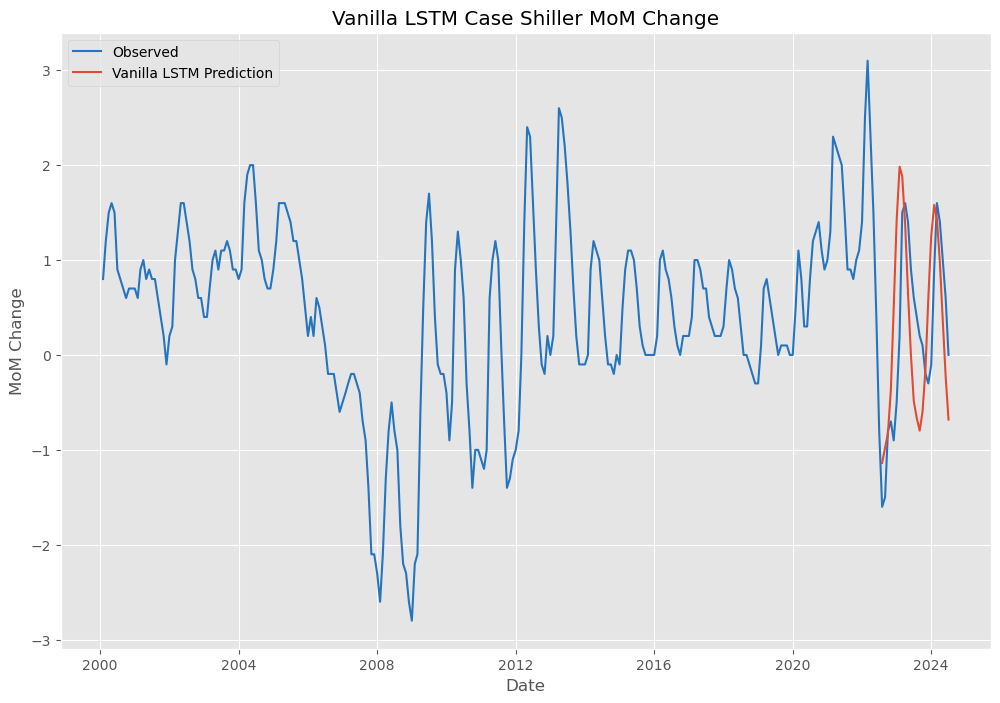

In [131]:
# line plot of observed vs predicted
rcParams['figure.figsize'] = 12, 8
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM Case Shiller MoM Change')
plt.xlabel('Date')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

#### Vanilla LSTM Performance Metrics

In [132]:
vanilla_lstm = performance(data_targets,final_vanilla)
vanilla_lstm

{'MSE': 1.81, 'RMSE': 1.35, 'MAPE': 3865.49}

## Stacked LSTM


#### Define Stacked LSTM Model

In [133]:
# Define the stacked LSTM model
class StackedLSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(StackedLSTMModel, self).__init__()
        # First LSTM layer (returns entire sequences)
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True, dropout=0.2 ,num_layers=2)
        # Second LSTM layer (returns entire sequences)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)
        #manual dropout
        self.dropout = nn.Dropout(0.2)
        # Fully connected layers
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        x = lstm_out2[:, -1, :]  # Get the last time step output
        #x = self.dropout(x)  # Apply dropout here
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Stacked LSTM Training

In [134]:
# Train and predict multiple times
store2 = np.zeros((n_input, n_runs))

for i in range(n_runs):
    # Initialize the model
    model_stacked = StackedLSTMModel(n_input=n_input, n_features=n_features).to(device)
    
    # Train the model
    train_model(model_stacked, train_loader, epochs)
    
    # Make predictions
    pred_list_s = []
    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model_stacked(batch).item()  # Get prediction
            pred_list_s.append(pred)
            # Update the batch by appending the predicted value
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)


    # Inverse transform the predictions and store them
    store2[:, i] = scaler.inverse_transform(np.array(pred_list_s).reshape(-1, 1)).flatten()

# Average the results across runs (if needed)
final_stacked = np.mean(store2, axis=1)

Epoch [25/100], Loss: 0.4153
Epoch [50/100], Loss: 0.1666
Epoch [75/100], Loss: 0.0118
Epoch [100/100], Loss: 0.0628
Epoch [25/100], Loss: 0.2942
Epoch [50/100], Loss: 0.1203
Epoch [75/100], Loss: 0.1216
Epoch [100/100], Loss: 0.1285
Epoch [25/100], Loss: 0.5175
Epoch [50/100], Loss: 0.1290
Epoch [75/100], Loss: 0.0392
Epoch [100/100], Loss: 0.0687


#### Stacked LSTM Predictions

In [135]:
print(final_stacked)
print(final_stacked.shape)

[-0.61863221 -0.54981754 -0.50758827 -0.43997977 -0.06543469  1.17193285
  1.95826691  1.92686018  1.53777747  1.06771051  0.45886338  0.01053521
 -0.12811632 -0.14688116 -0.14402304 -0.09575242  0.53072511  1.30860227
  1.76018159  1.62764056  1.26297422  0.76338753  0.2928109   0.04759963]
(24,)


#### Export Data

In [136]:
np.savetxt("CSMoM_Stacked_LSTM_Predictions.csv", final_stacked, fmt='%f', delimiter=",")

#### Stacked LSTM Predictions Visualization

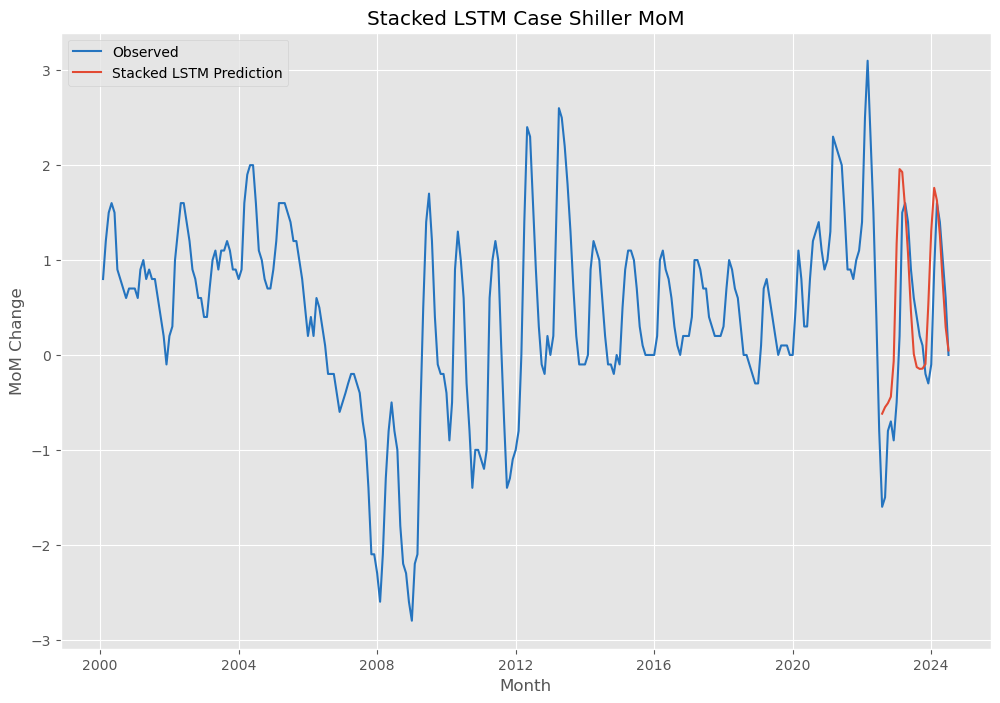

In [137]:
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_stacked,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM Case Shiller MoM')
plt.xlabel('Month')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

#### Stacked LSTM Performance Metrics

In [138]:
stacked_lstm = performance(data_targets,final_stacked)
stacked_lstm

{'MSE': 1.65, 'RMSE': 1.28, 'MAPE': 3409.74}

## Bidirectional LSTM

#### Define Bidirectional LSTM Model


In [139]:
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(BidirectionalLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Bidirectional LSTM Training

In [140]:
# Train and predict multiple times
store3 = np.zeros((n_input, n_runs))

for i in range(n_runs):
    # Initialize the model
    model_bidirec = BidirectionalLSTMModel(n_input=n_input, n_features=n_features).to(device)
    
    # Train the model
    train_model(model_bidirec, train_loader, epochs)
    
    # Make predictions
    pred_list_s = []
    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model_bidirec(batch).item()  # Get prediction
            pred_list_s.append(pred)
            # Update the batch by appending the predicted value
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)


    # Inverse transform the predictions and store them
    store3[:, i] = scaler.inverse_transform(np.array(pred_list_s).reshape(-1, 1)).flatten()

# Average the results across runs (if needed)
final_bidirec = np.mean(store3, axis=1)

Epoch [25/100], Loss: 0.3543
Epoch [50/100], Loss: 0.3040
Epoch [75/100], Loss: 0.1803
Epoch [100/100], Loss: 0.1380
Epoch [25/100], Loss: 0.5819
Epoch [50/100], Loss: 0.3783
Epoch [75/100], Loss: 0.4743
Epoch [100/100], Loss: 0.3936
Epoch [25/100], Loss: 0.5270
Epoch [50/100], Loss: 0.2090
Epoch [75/100], Loss: 0.1873
Epoch [100/100], Loss: 0.2274


#### Bidirectional LSTM Predictions

In [141]:
print(final_bidirec)
print(final_bidirec.shape)

[-8.69846145e-01 -8.36766491e-01 -8.56946357e-01 -5.89121543e-01
  3.05092192e-01  1.36020930e+00  2.07133794e+00  2.13676360e+00
  1.76844081e+00  1.14153901e+00  3.95753096e-01 -4.60202010e-04
 -2.27597012e-01 -2.21949804e-01 -3.12008505e-01 -1.83467671e-01
  3.09902375e-01  1.10587462e+00  1.69011344e+00  1.70871117e+00
  1.40706573e+00  9.23425523e-01  4.34723640e-01  6.49489363e-02]
(24,)


#### Export Data

In [142]:
np.savetxt("CSMoM_Bidirec_LSTM_Predictions.csv", final_bidirec, fmt='%f', delimiter=",")

#### Bidirectional LSTM Predictions Visualization

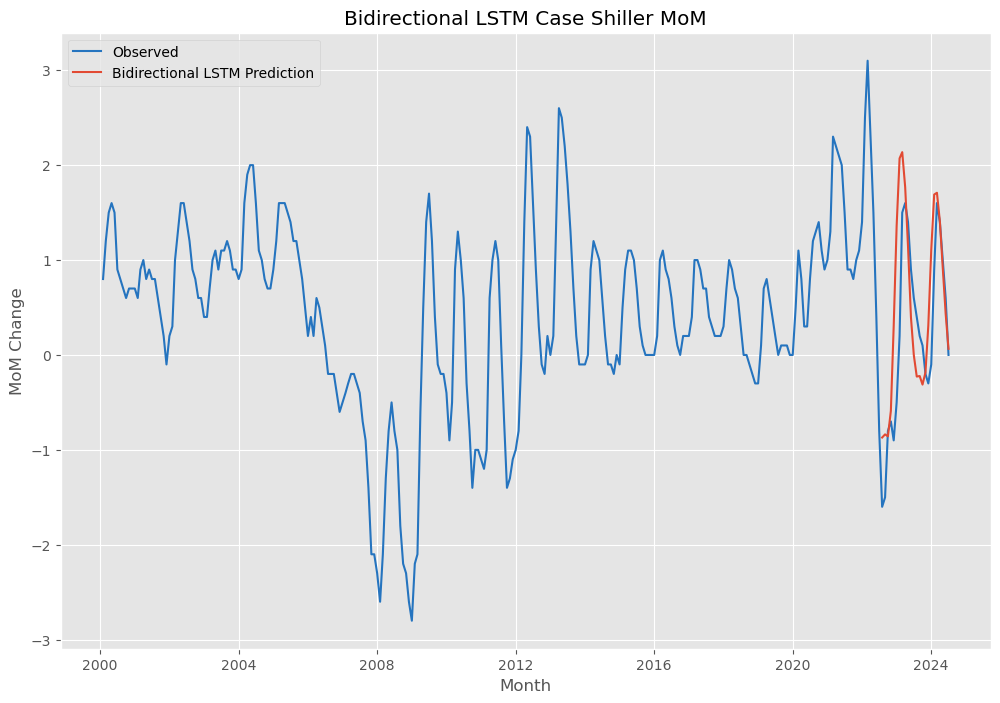

In [143]:
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_bidirec,label="Bidirectional LSTM Prediction")
plt.title('Bidirectional LSTM Case Shiller MoM')
plt.xlabel('Month')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

#### Bidirectional LSTM Performance Metrics

In [144]:
bidirec_lstm = performance(data_targets,final_bidirec)
bidirec_lstm

{'MSE': 1.84, 'RMSE': 1.36, 'MAPE': 3863.27}

## Convolutional Neural Network (CNN)

#### Define CNN Model

In [145]:
# CNN Model
class CNNModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(n_input, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128, 100)
        self.fc2 = nn.Linear(100,1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        # x = torch.avg_pool1d(x, kernel_size=3, padding=1, count_include_pad=False)
        x = torch.max_pool1d(x, kernel_size=3, padding=1)
        x = torch.flatten(x,1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### CNN Model Training

In [146]:
# Averaging over multiple runs (to keep the loop structure like in the original code)
store4 = np.zeros((n_input, n_runs))

for i in range(n_runs):
    #reset_weights(model)  # Reset the weights to random
    model = CNNModel(n_input, n_features).to(device)
    train_model(model, train_loader, epochs)
    pred_list = []

    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model(batch).item()
            pred_list.append(pred)
           # Update the batch by appending the prediction and removing the first element
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)

    store4[:, i] = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1)).flatten()

# Averaging predictions
final_cnn = np.mean(store4, axis=1)

Epoch [25/100], Loss: 0.0769
Epoch [50/100], Loss: 0.0053
Epoch [75/100], Loss: 0.0364
Epoch [100/100], Loss: 0.0003
Epoch [25/100], Loss: 0.0973
Epoch [50/100], Loss: 0.0315
Epoch [75/100], Loss: 0.0027
Epoch [100/100], Loss: 0.0006
Epoch [25/100], Loss: 0.0814
Epoch [50/100], Loss: 0.0097
Epoch [75/100], Loss: 0.0042
Epoch [100/100], Loss: 0.0013


#### CNN Predictions

In [147]:
print(final_cnn)
print(final_cnn.shape)

[-1.24249402 -1.26847711 -0.89644502 -0.61785983 -0.27580361  0.58646689
  1.18331192  1.12635471  0.68654611 -0.31247357 -1.25651738 -2.02547008
 -2.31471527 -2.11558997 -1.74773556 -1.13221072  0.15921063  1.18450121
  1.8251157   1.90735949  1.52204083  0.73930219 -0.03998561 -0.35032289]
(24,)


#### Export Data

In [148]:
np.savetxt("CSMoM_CNN_Predictions.csv", final_cnn, fmt='%f', delimiter=",")

#### CNN Predictions Visualization

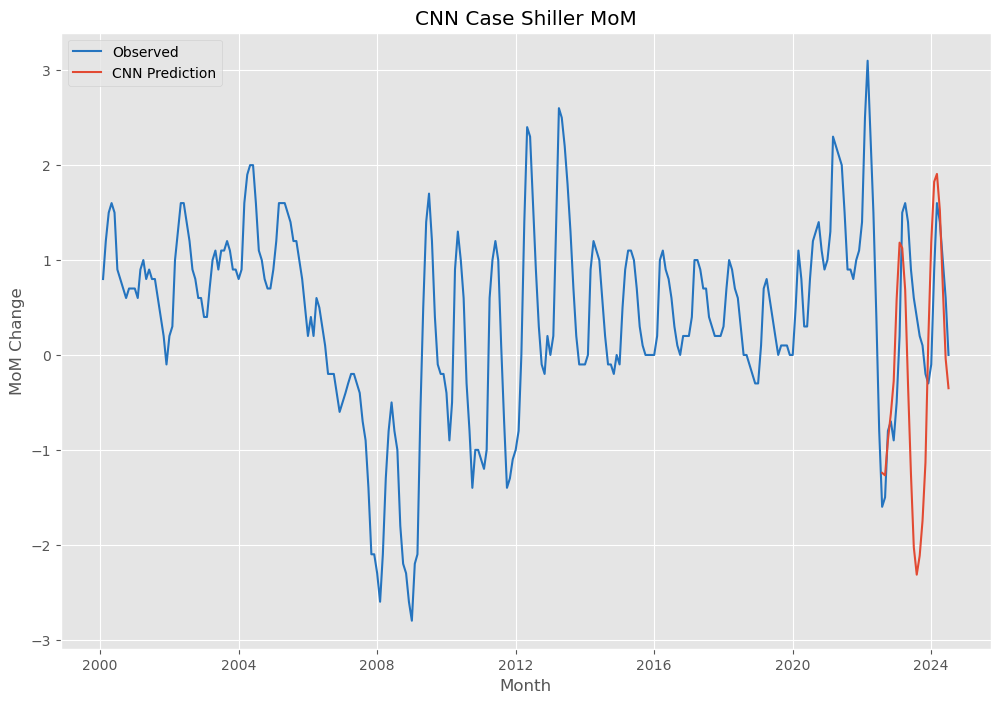

In [149]:
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_cnn,label="CNN Prediction")
plt.title('CNN Case Shiller MoM')
plt.xlabel('Month')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

#### CNN Performance Matrics

In [150]:
cnn = performance(data_targets,final_cnn)
cnn

{'MSE': 2.65, 'RMSE': 1.63, 'MAPE': 4889.51}

## Compare Results

#### Evaluation Metrics

In [151]:
print(f"Vanilla LSTM: {vanilla_lstm}")
print(f"Stacked LSTM: {stacked_lstm}")
print(f"Bidirec LSTM: {bidirec_lstm}")
print(f"Conv NN LSTM: {cnn}")

Vanilla LSTM: {'MSE': 1.81, 'RMSE': 1.35, 'MAPE': 3865.49}
Stacked LSTM: {'MSE': 1.65, 'RMSE': 1.28, 'MAPE': 3409.74}
Bidirec LSTM: {'MSE': 1.84, 'RMSE': 1.36, 'MAPE': 3863.27}
Conv NN LSTM: {'MSE': 2.65, 'RMSE': 1.63, 'MAPE': 4889.51}


#### Visualization

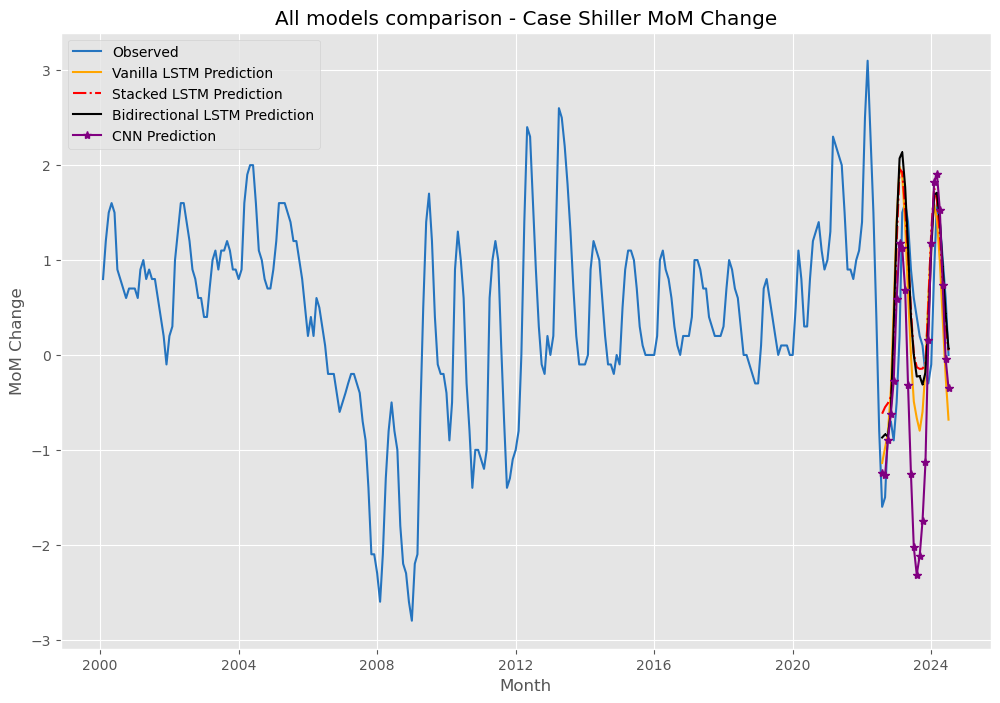

In [152]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data.index,data,label="Observed",color='#2574BF')
#Vanilla LSTM
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction",linestyle= "-", color='orange')
#Stacked LSTM
plt.plot(data[split:].index,final_stacked,label="Stacked LSTM Prediction",linestyle= "-.", color="red")
#Bidirectional LSTM
plt.plot(data[split:].index,final_bidirec,label="Bidirectional LSTM Prediction",marker=',',color='black')
#CNN model
plt.plot(data[split:].index,final_cnn,label="CNN Prediction",marker="*",color="purple")
plt.title('All models comparison - Case Shiller MoM Change')
plt.xlabel('Month')
plt.ylabel('MoM Change')
plt.legend(loc='upper left')
plt.show()